In [1]:
import os
import pandas as pd
import matplotlib.pyplot as pplot


# _fpath = 'init_hpp_train_runs'
_fpath = '.'
train_hist_files = [os.path.join(_fpath,f) for f in os.listdir(_fpath) if 'log_hist.pcl' in f]
train_hist = [pd.read_pickle(os.path.join(_fpath,f)) for f in train_hist_files]
[f for f in os.listdir('.') if 'log_hist.pcl' in f]

['0a712e8b644c271868cadec93359278c_log_hist.pcl',
 'bd223ca36d0bf2a747b355fd0377aea7_log_hist.pcl',
 'd245da498ff3b06dda62b7b4cf38e72f_log_hist.pcl',
 '0af2ddbe5e9c789a2e3789e061aebd51_log_hist.pcl']

Text(0, 0.5, 'Binary Cross-entropy')

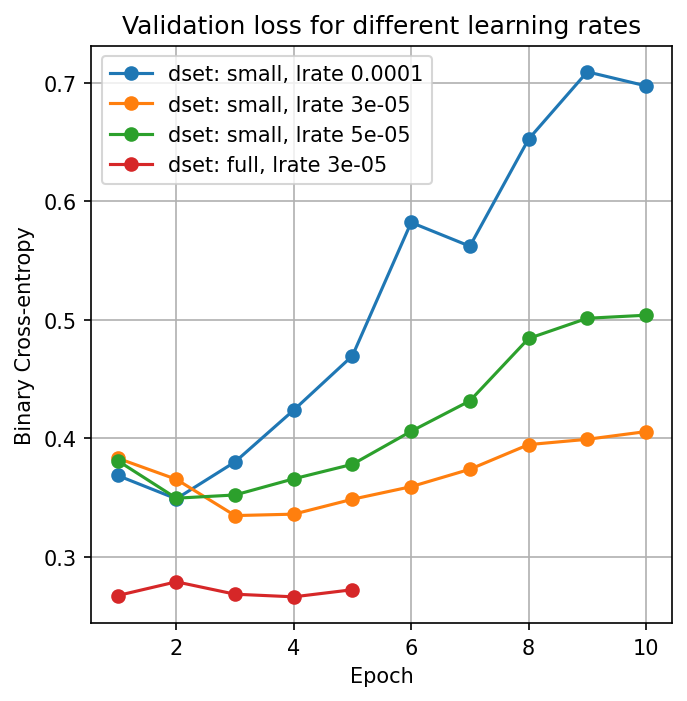

In [2]:
pplot.figure(figsize = (5,5), dpi = 150)
for t_f, t in zip(train_hist_files, train_hist):
    
    if '5dc2' in t_f:
        
        continue
    skip = t['skip_how_many'].values[0]
    if skip != 1:
        dset = 'small'
    else:
        dset = 'full'
    _t = t[~t['eval_loss'].isna()]
    x = list(_t['epoch'].values)
    y = list(_t['eval_loss'].values)
    pplot.plot(x, y, 'o-', label = f"dset: {dset}, lrate {t['lrate'][0]}")

pplot.legend()
pplot.grid()
pplot.title('Validation loss for different learning rates')
pplot.xlabel("Epoch"); pplot.ylabel("Binary Cross-entropy")

In [3]:
from src.utils import ResultsReader

In [4]:
rr = ResultsReader('./results_0af2ddbe5e9c789a2e3789e061aebd51/')
# rr.get_log_hist()['loss'].plot()
# dd = rr.get_log_hist()['eval_loss']
# dd[~dd.isna()].plot()

In [5]:
model, tokenizer = rr.load_best_model()
# model.push_to_hub('mylonasc/bart-base-twitter-sent-ft-001')

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


- loading model from ./results_0af2ddbe5e9c789a2e3789e061aebd51/checkpoint-19000, model_type: facebook/bart-base


In [6]:
# Load the dataset, and produce the same train-test split:
import numpy as np
from src.data_utils import TwitterDataClass, TorchTwitterDataset
seed = 1337
np.random.seed(seed)
tw = TwitterDataClass(load_cached_stage = 1)
d_train, d_test = tw.train_test_split()
# the d_test will only be used for assessing model performance.

In [7]:
import torch
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)

In [8]:
_ = model.eval()

In [9]:
from tqdm import tqdm 
def _get_is_positive_probs(d_test, model, tokenizer, batch_size = 512):
    preds_softmax = []
    preds_logits = []
    d_test_pt = TorchTwitterDataset(d_test, tokenizer=tokenizer)
    for bstart in tqdm(range(0, len(d_test_pt), batch_size)):
        with torch.no_grad():
            _dat = d_test_pt[bstart:bstart+batch_size]
            del _dat['label']
            res = model(**_dat)[0]
        # Normally this should have been sigmoid.
        preds_softmax.append(res.softmax(1)[:,1].cpu().numpy())
        preds_logits.append(res[:,1].sigmoid().cpu().numpy())
    return np.hstack(preds_softmax), np.hstack(preds_logits)

In [10]:
p1, p2 = _get_is_positive_probs(d_test, model, tokenizer, batch_size = 768)

100%|██████████| 521/521 [02:46<00:00,  3.14it/s]


In [11]:
p= p1
p_label = p > 0.5

In [12]:
from src.utils import binary_model_diagnostics

In [13]:
diags = binary_model_diagnostics(d_test['is_positive'].values, p_label)
diags

{'tn': np.float64(0.9038977923344251),
 'tp': np.float64(0.8895154176189903),
 'fp': np.float64(0.09633004531055776),
 'fn': np.float64(0.11022326674500588),
 'accuracy': np.float64(0.8967151192624726),
 'precision': np.float64(0.9022868705767509),
 'recall': np.float64(0.8895154176189903),
 'f1': np.float64(0.8958556284704695)}